In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

### Building dataset

In [3]:
words = open('../2_makemore_bigrams/names.txt','r').read().splitlines()

In [4]:
len(words)

32033

In [5]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
chars = sorted(list(set(''.join(words))))
stoi = {i:enum+1 for enum, i in enumerate(chars)}
stoi['.'] = 0
itos = {v:k for k,v in stoi.items()}

In [8]:
# build the dataset
block_size = 3

def build_dataset(words):
    X=[]
    Y=[]
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

In [14]:
import random
random.seed(42)
random.shuffle(words)

In [16]:
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

In [18]:
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Choosing best hyperparamters

In [21]:
device = torch.device('mps')
Xtr = Xtr.to(device)
Ytr = Ytr.to(device)
Xdev = Xdev.to(device)
Ydev = Ydev.to(device)
Xte = Xte.to(device)
Yte = Yte.to(device)

In [23]:
hyperparameter_space = {
    'n_emb' : [2, 10, 100],
    'n_hidden' : [100,200,400]
}

In [25]:
losses_grid = {}
for n_emb in hyperparameter_space['n_emb']:
    for n_hidden in hyperparameter_space['n_hidden']:
        print('------------------------------------------------')
        print(f"Iterating ... n_emb : {n_emb} n_hidden : {n_hidden}")
        g = torch.Generator(device=device).manual_seed(99)
        C = torch.randn((27, n_emb), generator=g, device=device)
        W1 = torch.randn((n_emb*3, n_hidden), generator=g, device=device)
        b1 = torch.randn(n_hidden, generator=g, device=device)
        W2 = torch.randn((n_hidden,27), generator=g, device=device)
        b2 = torch.randn(27, generator=g, device=device)
        parameters = [C, W1,W2,b1,b2]
        for p in parameters:
            p.requires_grad = True
        print(f"Total parameters : {sum(p.nelement() for p in parameters)}")
        for steps in range(30000):
            minibatch = torch.randint(0,Xtr.shape[0],(32,))
            emb = C[Xtr[minibatch]].view(-1, n_emb*3)
            l1 = torch.tanh(emb @ W1 + b1)
            logits = l1 @ W2 + b2
            loss_train = F.cross_entropy(logits, Ytr[minibatch])
            for p in parameters:
                p.grad = None
            loss_train.backward()
            lr = 0.1 if steps < 15000 else 0.01
            for p in parameters:
                p.data += -lr*p.grad

            with torch.no_grad():
                emb = C[Xdev].view(-1, n_emb*3)
                l1 = torch.tanh(emb @ W1 + b1)
                logits = l1 @ W2 + b2
                loss_dev = F.cross_entropy(logits, Ydev)
                
        losses_grid[f"n_emb_{n_emb}_n_hidden_{n_hidden}_loss_train"] = loss_train
        losses_grid[f"n_emb_{n_emb}_n_hidden_{n_hidden}_loss_dev"] = loss_dev
        print(f"loss_train | loss_dev : {round(loss_train.item(),3)} | {round(loss_dev.item(),3)}")


------------------------------------------------
Iterating ... n_emb : 2 n_hidden : 100
Total parameters : 3481
loss_train | loss_dev : 2.521 | 2.364
------------------------------------------------
Iterating ... n_emb : 2 n_hidden : 200
Total parameters : 6881
loss_train | loss_dev : 2.325 | 2.349
------------------------------------------------
Iterating ... n_emb : 2 n_hidden : 400
Total parameters : 13681
loss_train | loss_dev : 2.265 | 2.339
------------------------------------------------
Iterating ... n_emb : 10 n_hidden : 100
Total parameters : 6097
loss_train | loss_dev : 1.948 | 2.293
------------------------------------------------
Iterating ... n_emb : 10 n_hidden : 200
Total parameters : 11897
loss_train | loss_dev : 2.509 | 2.319
------------------------------------------------
Iterating ... n_emb : 10 n_hidden : 400
Total parameters : 23497
loss_train | loss_dev : 2.512 | 2.337
------------------------------------------------
Iterating ... n_emb : 100 n_hidden : 100
Tota

```Best HP - n_emb : 100 n_hidden : 100```

### Final Training run

In [30]:
n_emb = 100
n_hidden = 100
losses_train = []
losses_dev = []
g = torch.Generator(device=device).manual_seed(99)
C = torch.randn((27, n_emb), generator=g, device=device)
W1 = torch.randn((n_emb*3, n_hidden), generator=g, device=device)
b1 = torch.randn(n_hidden, generator=g, device=device)
W2 = torch.randn((n_hidden,27), generator=g, device=device)
b2 = torch.randn(27, generator=g, device=device)
parameters = [C, W1,W2,b1,b2]
for p in parameters:
    p.requires_grad = True
print(f"Total parameters : {sum(p.nelement() for p in parameters)}")
for steps in range(200000):
    minibatch = torch.randint(0,Xtr.shape[0],(32,))
    emb = C[Xtr[minibatch]].view(-1, n_emb*3)
    l1 = torch.tanh(emb @ W1 + b1)
    logits = l1 @ W2 + b2
    loss_train = F.cross_entropy(logits, Ytr[minibatch])
    for p in parameters:
        p.grad = None
    loss_train.backward()
    lr = 0.1 if steps < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    losses_train.append(loss_train.log10().item())
    with torch.no_grad():
        emb = C[Xdev].view(-1, n_emb*3)
        l1 = torch.tanh(emb @ W1 + b1)
        logits = l1 @ W2 + b2
        loss_dev = F.cross_entropy(logits, Ydev)
        losses_dev.append(loss_dev.log10().item())
        
print(f"loss_train | loss_dev : {round(loss_train.item(),3)} | {round(loss_dev.item(),3)}")


Total parameters : 35527
loss_train | loss_dev : 1.876 | 2.159


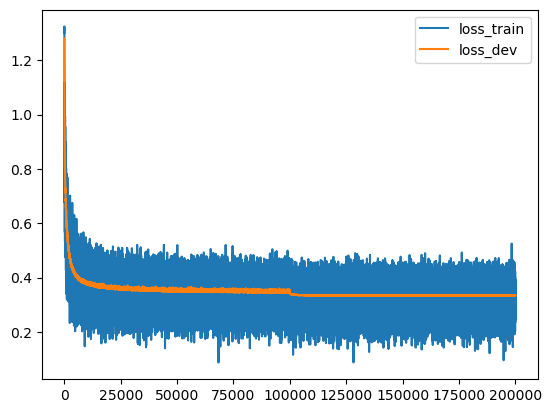

In [31]:
plt.plot(list(range(len(losses_train))), losses_train, label='loss_train')
plt.plot(list(range(len(losses_dev))), losses_dev, label='loss_dev')
plt.legend()

In [38]:
emb = C[Xte].view(-1, n_emb*3)
l1 = torch.tanh(emb @ W1 + b1)
logits = l1 @ W2 + b2
loss_te = F.cross_entropy(logits, Yte)
print(f"Loss test : {round(loss_te.item(),3)}")

Loss test : 2.158


### Visualize dimensions

In [45]:
from sklearn.decomposition import PCA

In [47]:
pca = PCA(n_components=2, random_state=42)

In [63]:
C_2d = pca.fit_transform(C.to(torch.device('cpu')).detach().numpy())

In [65]:
C_2d.shape

(27, 2)

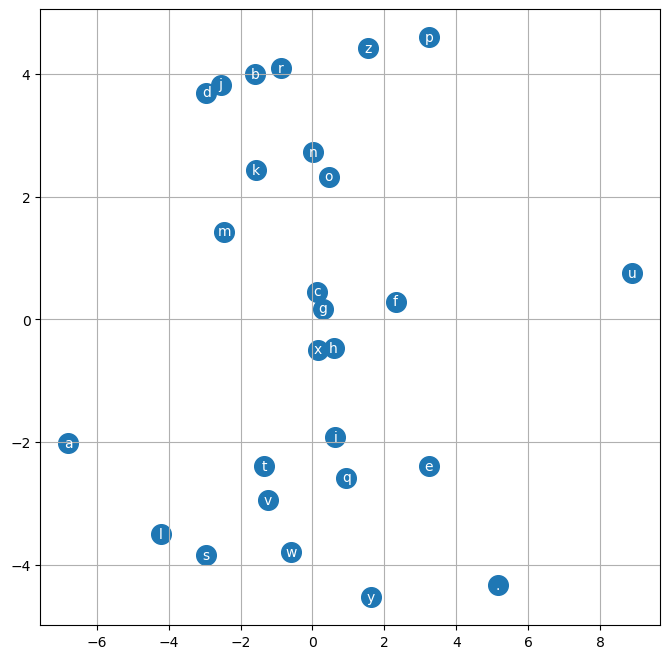

In [87]:
plt.figure(figsize=(8,8))
plt.scatter(C_2d[:,0], C_2d[:,1], s=200)
for i in range(C_2d.shape[0]):
    plt.text(C_2d[i,0],C_2d[i,1], itos[i], ha='center',va='center',color='white')
plt.grid()

### Sample genereated from model  

In [94]:
torch.tensor([[0,1,2]]).shape

torch.Size([1, 3])

In [98]:
g = torch.Generator(device=torch.device('mps')).manual_seed(23123)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join([itos[i] for i in out]))

alha.
clinson.
maine.
amuquantennandijah.
caterrah.
bra.
olinesstefulberti.
jahdenja.
colena.
mijahyanna.
jah.
kyanne.
shel.
shyan.
jasiah.
afvonney.
kawshan.
ren.
jelenan.
mariah.
